Произведем отбор признаков с помощью разных методов. Составим разные списки признаков, отсортированных по важности. И на основе этих списков будем строить разные модели машинного обучения.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.float_format ='{:,.2f}'.format

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, RFE, f_classif 
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from tqdm import tqdm

In [3]:
# # Загрузка библиотек
# from lazypredict.Supervised import LazyClassifier
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.preprocessing import StandardScaler, normalize, RobustScaler, MinMaxScaler
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
# from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import NuSVC, SVC





Загружаем датасеты. Так как они идентичные, то будем как и при отборе для удаления признаков выссокой корреляции использовать один датасет

In [4]:
df = pd.read_csv('database/df_2019_full.csv')
target = pd.read_csv('database/target_2019_01_full.csv')
target = target['target_2019 01']

Считаем список коллинеарных признаков, которые отобрали на предыдущем этапе для удаления.

In [5]:
file = open('feature_list/fs_collinear.txt', 'r')
list__f_collinear = [line.strip() for line in file]
file.close()

Удаляем на коллинеарные признаки и смотрим, что получилось

In [6]:
df = df.drop(list__f_collinear, axis=1)

Посмотрим тепловую карту корреляции

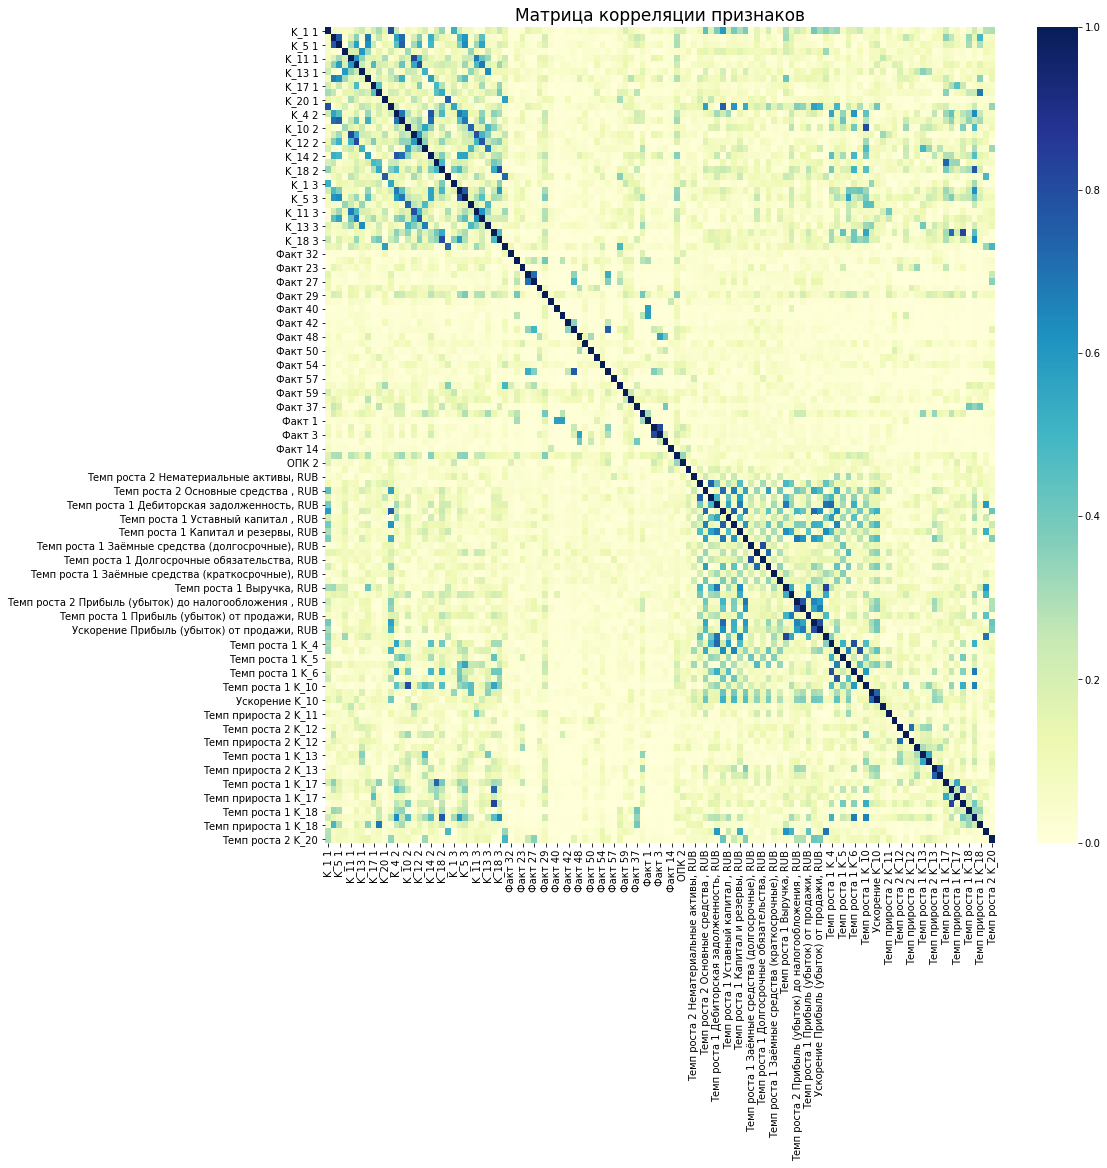

In [7]:
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(df.corr().abs(), vmin=0, vmax=1, cmap="YlGnBu")
heatmap.set_title('Матрица корреляции признаков', fontsize=17); 

In [8]:
print(f'По итогу у нас {df.shape[0]} объекта и {df.shape[1]} признака.')

По итогу у нас 325 объекта и 117 признака.


Проверим с помощью функций

In [9]:
def make_corr_df(df, threshold_corr=0.8):
    """Формирует датафрейм с сильными корреляционными зависимостями
    threshold_corr = верхний порог корреляции, по умолчанию 0.8"""
    
    cr = df.corr().abs().unstack().sort_values(ascending=False)
    cr = pd.DataFrame(cr).reset_index()
    cr.columns = ['f1', 'f2', 'corr']
    cr = cr[(cr['corr'] > threshold_corr) & (cr['f1'] != cr['f2'])]
    
    return cr

# ----------------------

def corr_groups(cr):
    """Формирует группы коррелирующих признаков"""
    
    correlated_groups = []
    for f in cr['f1'].unique():
        correlated_block = cr[cr['f1'] == f]
        cur_dups = list(correlated_block['f2'].unique()) + [f]
        correlated_groups.append(cur_dups)
    
    return correlated_groups
        

In [10]:
# Список групп коррелирующих между собой признаков
correlated_groups = corr_groups(make_corr_df(df, 0.85))
print(len(correlated_groups), 'групп коррелирующих признаков')

0 групп коррелирующих признаков


**Востользуемся разными методами отбора признаков**

In [11]:
# Стандартизируем для некоторых методик
scaler = StandardScaler()
df_standard = scaler.fit_transform(df)

**mutual_info_classif**

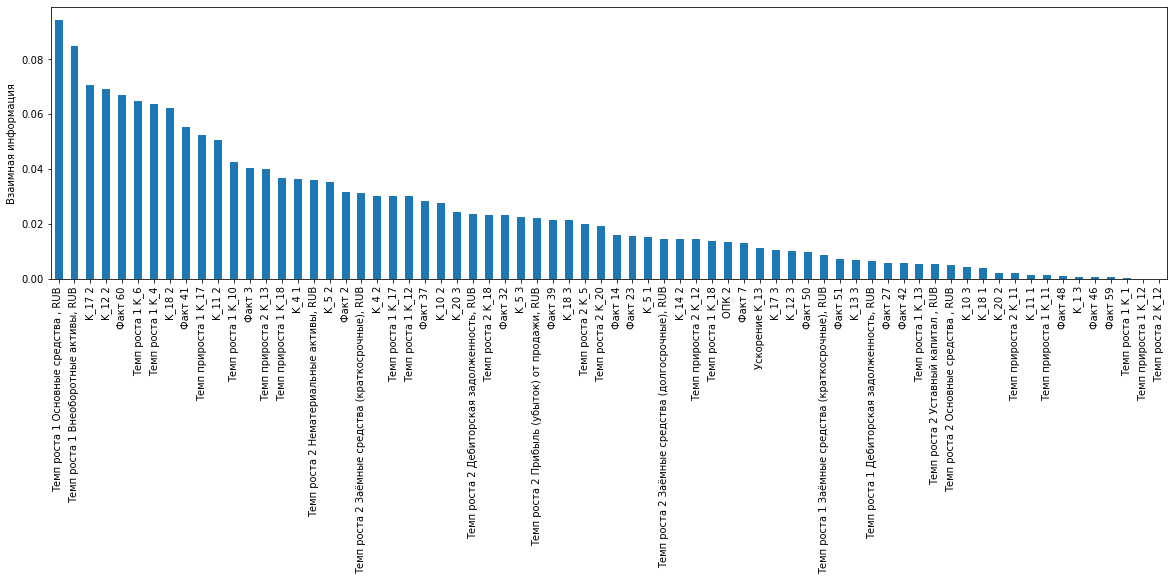

In [12]:
# Отбор, основанный на взаимной информации
mi = mutual_info_classif(df_standard, target)
mi = pd.Series(mi)
mi.index = df.columns
mi = mi.sort_values(ascending=False)
mi[:70].plot.bar(figsize=(20,5))
plt.ylabel('Взаимная информация')
plt.show()

In [13]:
# Список признаков, отобранный с помощью mutual_info_classif 
f_mi = list(mi.index)

In [14]:
# Запись в файл списка признаков
file = open('feature_list/f_mi_importances.txt', 'w')
for index in f_mi:
     file.write(index + '\n')
file.close()

**permutation_importance**

In [15]:
# Создадим модель на основании которой будем производить отбор признаков
rfc_model = RandomForestClassifier(max_depth=5, random_state=42).fit(df, target)

In [16]:
result_f1 = permutation_importance(rfc_model, df, target, n_repeats=10, random_state=42, scoring='f1' )

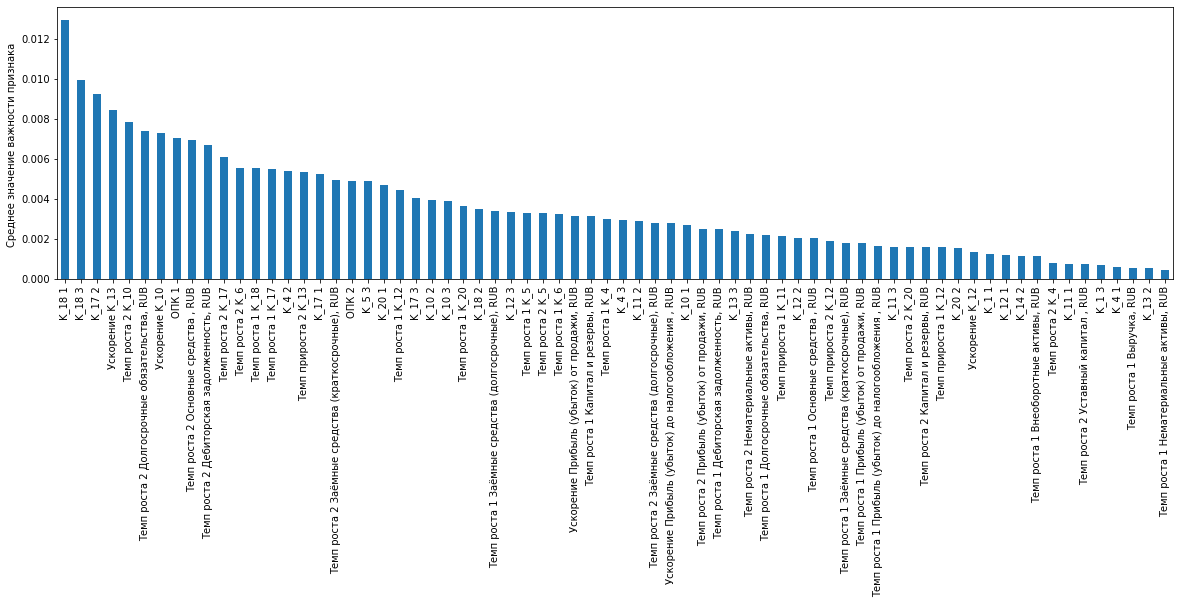

In [17]:
pi_f1 = pd.Series(result_f1.importances_mean)
pi_f1.index = df.columns
pi_f1 = pi_f1.sort_values(ascending=False)
pi_f1[:70].plot.bar(figsize=(20,5))
plt.ylabel('Среднее значение важности признака ')
plt.show()

In [18]:
# Запись в файл списка признаков
file = open('feature_list/f_pi_f1_importances.txt', 'w')
for index in pi_f1.index:
     file.write(index + '\n')
file.close()

In [19]:
result_ra = permutation_importance(rfc_model, df, target, n_repeats=10, random_state=42, scoring='roc_auc' )

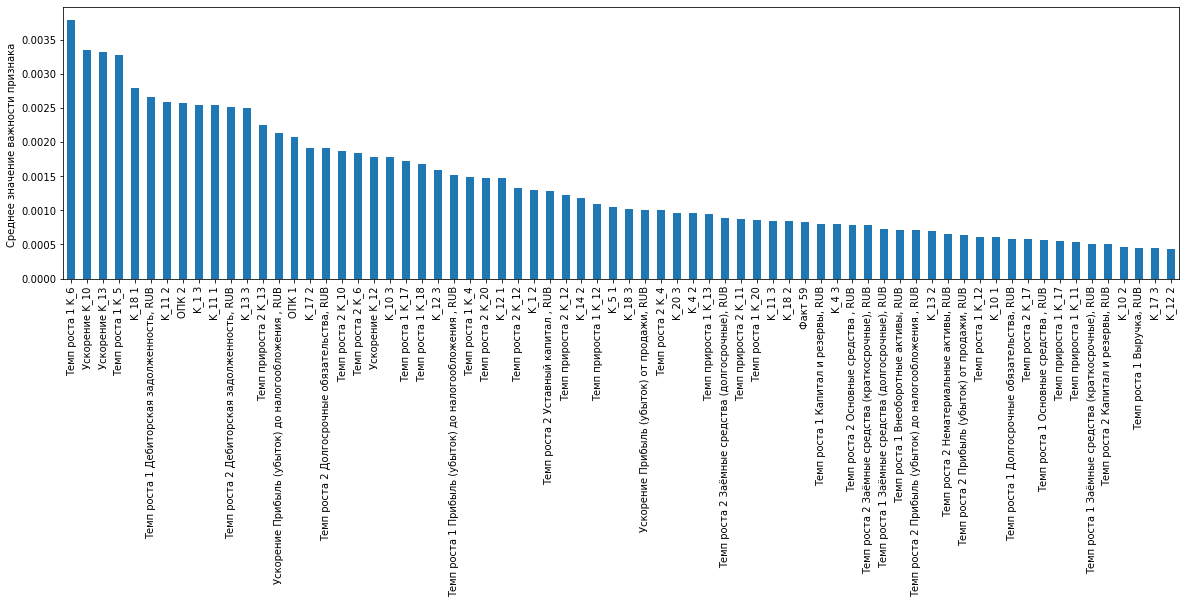

In [20]:
pi_ra = pd.Series(result_ra.importances_mean)
pi_ra.index = df.columns
pi_ra = pi_ra.sort_values(ascending=False)
pi_ra[:70].plot.bar(figsize=(20,5))
plt.ylabel('Среднее значение важности признака ')
plt.show()

In [21]:
# Запись в файл списка признаков
file = open('feature_list/f_pi_ra_importances.txt', 'w')
for index in pi_ra.index:
     file.write(index + '\n')
file.close()

**Recursive feature elimination**

In [22]:
result_rfe =  RFE(rfc_model, step=1, n_features_to_select=60)
result_rfe = result_rfe.fit(df, target)
f_rfe_all = list(zip(df.columns, result_rfe.ranking_))

In [23]:
# отберем с 1
f_rfe = []
for i in f_rfe_all:
    if i[1] == 1:
        f_rfe.append(i[0])

len(f_rfe)        

60

In [24]:
# Запись в файл списка признаков
file = open('feature_list/f_rfe_importances.txt', 'w')
for index in f_rfe:
     file.write(index + '\n')
file.close()

**LogisticRegression**

In [25]:
lr_model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=200, class_weight='balanced',
                              random_state=42).fit(df_standard, target)


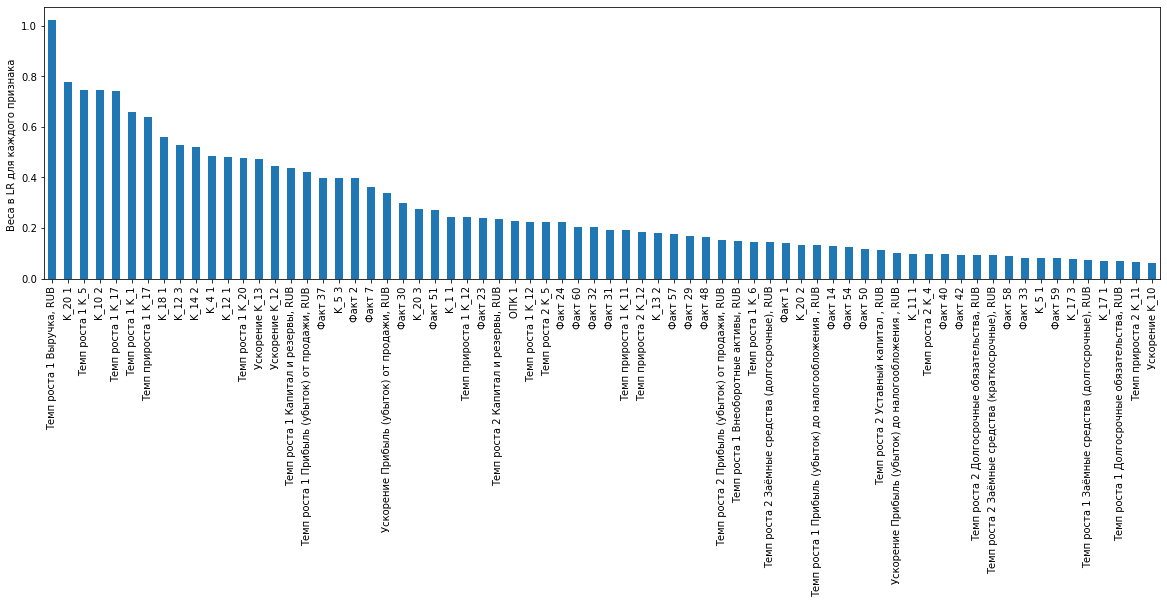

In [26]:
f_lr = pd.Series(list(lr_model.coef_[0]))
f_lr.index = df.columns
f_lr = f_lr.abs().sort_values(ascending=False)
f_lr[:70].plot.bar(figsize=(20,5))
plt.ylabel('Веса в LR для каждого признака ')
plt.show()

In [27]:
# Запись в файл списка признаков
file = open('feature_list/f_lr_importances.txt', 'w')
for index in f_lr.index:
     file.write(index + '\n')
file.close()

**f_classif**

In [28]:
result_f = f_classif(df_standard, target)

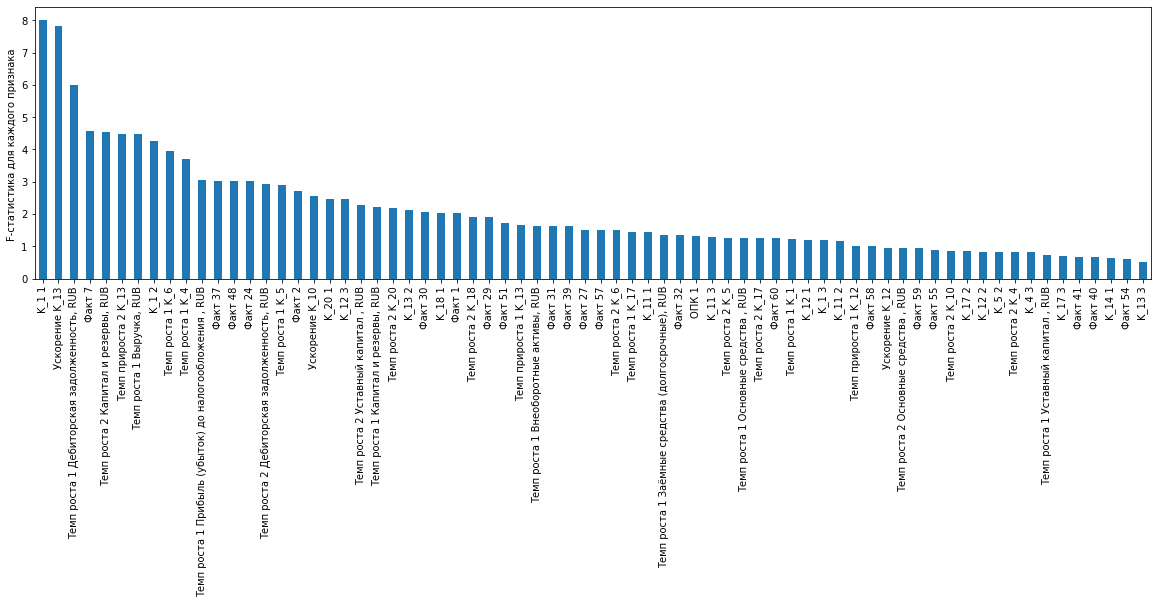

In [29]:
f_cl = pd.Series(result_f[0])
f_cl.index = df.columns
f_cl = f_cl.sort_values(ascending=False)
f_cl[:70].plot.bar(figsize=(20,5))
plt.ylabel('F-статистика для каждого признака ')
plt.show()

In [30]:
# Запись в файл списка признаков
file = open('feature_list/f_cl_importances.txt', 'w')
for index in f_cl.index:
     file.write(index + '\n')
file.close()